1. 데이터 Loading

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cvx
drive.mount('/content/drive')
url='/content/drive/MyDrive/Social_Network_Ads.csv'
df=pd.read_csv(url)

Mounted at /content/drive


2. 데이터 전처리(preprocessing), Feature 추출

In [2]:
X = df[['Age', 'EstimatedSalary']]
y = df['Purchased']

3. 학습 데이터를 데이터의 80%(320개), 테스트 데이터를 20%(80개)로 분할 사용

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(320, 2) (80, 2)
(320,) (80,)


4. 학습데이터에 대해 로지스틱회귀 모델 구성

In [19]:
def sigmoid(z): #시그모이드 함수
  z = np.clip(z, -500, 500) #오버플로우 발생으로 z의 범위를 정했음
  return 1/(1+np.exp(-z))
def predict(X, w, b): #예측함수
  z=np.dot(X, w) + b
  return sigmoid(z)
def compute_cost(y, p): #손실(Cost) 함수
  m = len(y)
  return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

5-1. 경사하강법을 이용해서 모델 학습

In [20]:
def train_logistic_regression(X, y, lr=0.01, ephocs=1000):
    # 가중치 초기화
    m, n = X.shape
    w = np.zeros(n)
    b = 0

    # 경사 하강법 (Gradient Descent)
    for i in range(ephocs):
        # 시그모이드 함수로 예측값 계산
        z = np.dot(X, w) + b
        p = sigmoid(z)

        # 비용 함수의 기울기 계산
        dw = (1/m) * np.dot(X.T, (p - y))
        db = (1/m) * np.sum(p - y)

        # 가중치 업데이트
        w -= lr * dw
        b -= lr * db

    return b, w

5-2. 파라미터 값 출력

In [21]:
X_train_np = X_train.values
y_train_np = y_train.values

# 모델 학습
w0, w = train_logistic_regression(X_train_np, y_train_np)
w1, w2 = w[0], w[1]

# 결과 출력
print(f"학습된 파라미터:")
print(f"w0 (bias): {w0}")
print(f"w1 (Age): {w1}")
print(f"w2 (EstimatedSalary): {w2}")

학습된 파라미터:
w0 (bias): -0.8024999999999876
w1 (Age): 0.45487499999999226
w2 (EstimatedSalary): 160.875


6. 모델의 시각화

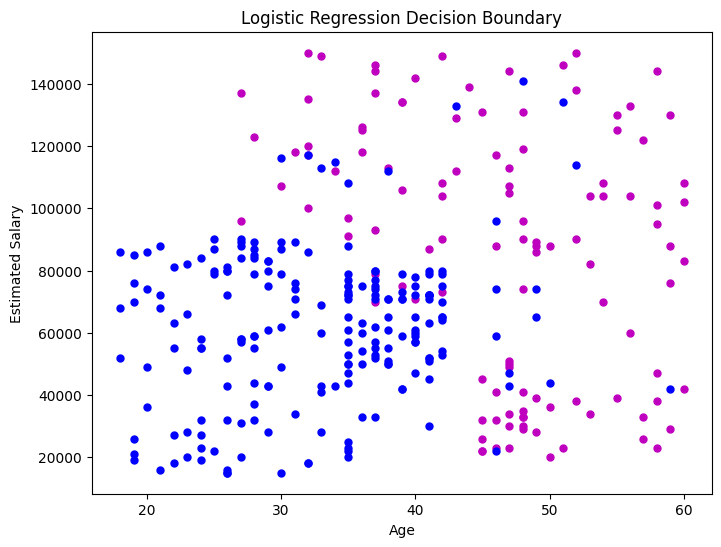

In [22]:
# 결정 경계 그리기
x_min, x_max = X_train_np[:, 0].min() - 1, X_train_np[:, 0].max() + 1  # Age 범위
y_min, y_max = X_train_np[:, 1].min() - 1, X_train_np[:, 1].max() + 1000  # EstimatedSalary 범위

# 그리드 포인트 생성
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1.0),
                     np.arange(y_min, y_max, 1000.0)) #두 개의 1D 배열(x, y)을 받아서, 2D 격자좌표 행렬 두 개를 만드는 함수

# 각 그리드 포인트에서 예측값 계산
Z = sigmoid(np.dot(np.c_[xx.ravel(), yy.ravel()], w) + w0)  # 예측
Z = Z.reshape(xx.shape)  # 그리드의 형태로 변환

# 데이터 포인트 그리기
plt.figure(figsize=(8, 6))
# 클래스별로 데이터 나누기
X1 = X_train_np[y_train_np == 1]  # Purchased = 1
X0 = X_train_np[y_train_np == 0]  # Purchased = 0
# "구매"와 "미구매" 데이터 포인트 시각화
plt.plot(X1[:,0], X1[:,1], 'mo', markersize = 5, label='Purchased = 1')
plt.plot(X0[:,0], X0[:,1], 'bo', markersize = 5, label='Purchased = 0')

plt.title("Logistic Regression Decision Boundary")
plt.xlabel("Age")
plt.ylabel("Estimated Salary")
plt.axis('auto')
plt.show()


7. scikit-learn Library를 이용, 모델 학습, 파라미터 값 출력

In [23]:
# 모델 생성 & 학습
model = LogisticRegression()
model.fit(X_train_np, y_train_np)

# 파라미터 추출
w0 = model.intercept_[0]     # bias
w1, w2 = model.coef_[0]      # weights

# 출력
print("scikit-learn 학습 결과:")
print(f"w0 (bias): {w0}")
print(f"w1 (Age): {w1}")
print(f"w2 (EstimatedSalary): {w2}")

scikit-learn 학습 결과:
w0 (bias): -12.204652213162195
w1 (Age): 0.2296250725525272
w2 (EstimatedSalary): 3.4308261415740086e-05


8. 모델의 시각화

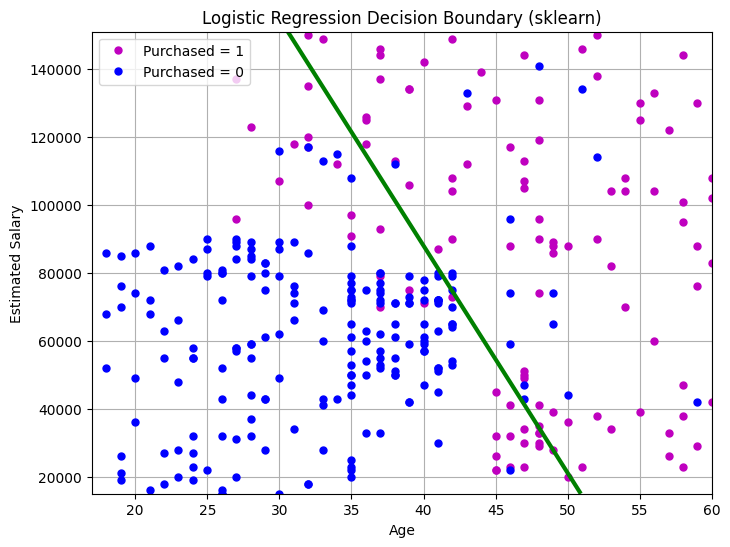

In [24]:
# 각 포인트에서 예측 (0 또는 1일 확률)
grid = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict_proba(grid)[:, 1]  # 클래스 1일 확률
Z = Z.reshape(xx.shape)

# 시각화
plt.figure(figsize=(8, 6))

# 실제 데이터 포인트 찍기
X1 = X_train_np[y_train_np == 1]
X0 = X_train_np[y_train_np == 0]
plt.plot(X1[:, 0], X1[:, 1], 'mo', markersize=5, label='Purchased = 1')
plt.plot(X0[:, 0], X0[:, 1], 'bo', markersize=5, label='Purchased = 0')

# 결정 경계 선
plt.contour(xx, yy, Z, levels=[0.5], colors='g', linestyles='-',linewidths=3)

plt.xlabel("Age")
plt.ylabel("Estimated Salary")
plt.title("Logistic Regression Decision Boundary (sklearn)")
plt.legend()
plt.grid(True)
plt.show()